## Metrics for goodness/quality of trees -- Local posterior probability from ASTRAL-pro2 and normalized Robinson-Foulds distance to WoL2 tree

In [1]:
import sys
import pandas as pd
import numpy as np
from skbio.tree import TreeNode
import matplotlib.pyplot as plt

In [2]:
import dendropy
from dendropy.calculate.treecompare import unweighted_robinson_foulds_distance
from scipy.stats import mannwhitneyu, false_discovery_control

In [3]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

In [4]:
def shared_taxa(tree1, tree2):
    taxa1 = {node.taxon.label for node in tree1.leaf_node_iter()}
    taxa2 = {node.taxon.label for node in tree2.leaf_node_iter()}
    return list(taxa1.intersection(taxa2)), taxa1, taxa2

In [5]:
def count_internal_branches(tree):
    """
    Calculate the number of internal branches in a phylogenetic tree.

    Parameters
    ----------
    tree : dendropy.Tree
        A phylogenetic tree represented by a dendropy Tree object.

    Returns
    -------
    int
        The number of internal branches (edges) in the tree.
    """
    # Internal branches are the edges between internal nodes
    internal_branches = 0
    
    for edge in tree.postorder_edge_iter():
        if not edge.is_leaf() and edge.tail_node is not None:  # Check if it's an internal branch
            internal_branches += 1
    
    return internal_branches

In [6]:
def RF_distance(treeA, treeB, norm = True, **kwargs):
    
    treeA_copy, treeB_copy = dendropy.Tree(treeA), dendropy.Tree(treeB)
    
    # Prune trees such that they contain the same taxa, otherwise RF is much larger
    taxa_to_keep, taxa1, taxa2 = shared_taxa(treeA_copy, treeB_copy)
    if len(taxa_to_keep) < len(taxa1) or len(taxa_to_keep) < len(taxa2):
        treeA_copy.retain_taxa_with_labels(taxa_to_keep)
        treeB_copy.retain_taxa_with_labels(taxa_to_keep)
        
    # Update bipartition
    treeA_copy.update_bipartitions()
    treeB_copy.update_bipartitions()
    
    # Assuming trees share the same taxon name space
    rf = unweighted_robinson_foulds_distance(treeA_copy, treeB_copy)
    if norm:
        # Normalize by the maximal possible distance: which is the sum of internal branches
        # between both trees. Alternatively, if both trees are unrooted and binary, the sum
        # is always 2n - 6, where n is the number of tips in the tree.
        max_dist = 2 * len(taxa_to_keep) - 6
        # Number of internal branches
        n, m = count_internal_branches(treeA_copy), count_internal_branches(treeB_copy)
        if len(taxa_to_keep) > 3:
            # rf = rf / max_dist
            rf = rf / (n + m)
        else:
            rf = 0.0

    # Ratio between species in inferred to actual species tree
    ratio_sps = len(taxa2) / len(taxa1)
    # print(f'Ratios of sps: {ratio_sps}')
    
    return rf

In [7]:
def sig_sign(p_value):
    if p_value > 0.05:
        return 'n.s.'
    elif p_value > 0.01:
        return '*'
    elif p_value > 0.001:
        return '**'
    elif p_value > 0.0001:
        return '***'
    else:
        return '****'

## Marker genes selected with our approach

In [8]:
taxon_namespace = dendropy.TaxonNamespace()

WoL2 tree

In [9]:
wol_tree = dendropy.Tree.get(path = f'./tree.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [10]:
# Parameters
replicates = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ks = [50, 100, 200, 400]
p = 0

In [11]:
trees_kegg = {}
metadata_kegg = {}
for rep in replicates:
    dataPathIn = f'./out/replicate_{rep}/parsed/kegg' 
    trees_kegg[rep] = {}
    metadata_kegg[rep] = {}
    for k in ks:
        metadata_kegg[rep][k] = pd.read_table(f'{dataPathIn}/metadata_k_{k}_p_{p}_astral-pro2.tsv', index_col = 0)
        trees_kegg[rep][k] = dendropy.Tree.get(path = f'{dataPathIn}/nid_k_{k}_p_{p}_astral-pro2.nwk', schema = 'newick',
                                                  taxon_namespace = taxon_namespace)

In [12]:
trees_eggnog = {}
metadata_eggnog = {}
for rep in replicates:
    dataPathIn = f'./out/replicate_{rep}/parsed/eggnog' 
    trees_eggnog[rep] = {}
    metadata_eggnog[rep] = {}
    for k in ks:
        metadata_eggnog[rep][k] = pd.read_table(f'{dataPathIn}/metadata_k_{k}_p_{p}_astral-pro2.tsv', index_col = 0)
        trees_eggnog[rep][k] = dendropy.Tree.get(path = f'{dataPathIn}/nid_k_{k}_p_{p}_astral-pro2.nwk', schema = 'newick',
                                                  taxon_namespace = taxon_namespace)

## Previous marker sets

Martinez-Gutierrez (k = 41), Moody (k = 57), Amphora2 (k = 136), PhylophAn3 (k = 400)

In [13]:
# Parameters
replicates = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
markers = ['martinez_gutierrez', 'moody_2024', 'amphora', 'phylophlan']
ks = [41, 57, 136, 400]

In [14]:
trees_previous = {}
metadata_previous = {}
for rep in replicates:
    trees_previous[rep] = {}
    metadata_previous[rep] = {}
    for marker, k in zip(markers, ks):
        dataPathIn = f'./out/replicate_{rep}/parsed/{marker}' 
        trees_previous[rep][marker] = dendropy.Tree.get(path = f'{dataPathIn}/nid_k_{k}_astral-pro2.nwk', schema = 'newick',
                                                  taxon_namespace = taxon_namespace)
        metadata_previous[rep][marker] = pd.read_table(f'{dataPathIn}/metadata_k_{k}_astral-pro2.tsv', index_col = 0)

## LPP

In [15]:
replicates = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ks = [50, 100, 200, 400]

In [16]:
lpp_kegg = np.empty((len(replicates), len(ks)), dtype = float)
for i, rep in enumerate(replicates):
    for j, k in enumerate(ks):
        # Get lpp values
        datum = metadata_kegg[rep][k]['pp1'].values
        # print(f'At replicate {rep}, k {k}, lpp values for KEGG: {np.sum(datum >= 0.95) / len(datum)}')
        lpp_kegg[i, j] = np.sum(datum >= 0.95) / len(datum)

In [17]:
lpp_kegg.shape

(10, 4)

In [18]:
lpp_eggnog = np.empty((len(replicates), len(ks)), dtype = float)
for i, rep in enumerate(replicates):
    for j, k in enumerate(ks):
        # Get lpp values
        datum = metadata_eggnog[rep][k]['pp1'].values
        # print(f'At replicate {rep}, k {k}, lpp values for EggNOG: {np.sum(datum >= 0.95) / len(datum)}')
        lpp_eggnog[i, j] = np.sum(datum >= 0.95) / len(datum)

In [19]:
lpp_eggnog.shape

(10, 4)

In [20]:
replicates =[0, 1, 2, 3, 4, 5]
markers = ['martinez_gutierrez', 'moody_2024', 'amphora', 'phylophlan']
ks = [41, 57, 136, 400]

In [21]:
lpp_previous = np.empty((len(replicates), len(markers)), dtype = float)
for i, rep in enumerate(replicates):
    for j, marker in enumerate(markers):
        # Get lpp values
        datum = metadata_previous[rep][marker]['pp1'].values
        # print(f'At replicate {rep}, k {k}, lpp values for {marker}: {np.sum(datum >= 0.95) / len(datum)}')
        lpp_previous[i, j] = np.sum(datum >= 0.95) / len(datum)

In [22]:
lpp_previous.shape

(6, 4)

Mann-Whitney test with Benjamini-Hochberg correction

In [23]:
ks_kegg_eggnog = [50, 100, 200, 400]
ks_previous = [41, 57, 136, 400]

In [24]:
results_lpp_kegg = {}
results_lpp_eggnog = {}
for i, k1 in enumerate(ks_kegg_eggnog):
    # Store p-values
    pvals_kegg = [] 
    pvals_eggnog = []
    for j, k2 in enumerate(ks_previous):
        stat_kegg, p_value_kegg = mannwhitneyu(lpp_kegg[:, i], lpp_previous[:, j])
        pvals_kegg.append([f'k1_{k1}_k2_{k2}', stat_kegg, p_value_kegg])
        stat_eggnog, p_value_eggnog = mannwhitneyu(lpp_eggnog[:, i], lpp_previous[:, j])
        pvals_eggnog.append([f'k1_{k1}_k2_{k2}', stat_eggnog, p_value_eggnog])
    # Store as dataframe
    results_lpp_kegg[k1] = pd.DataFrame(pvals_kegg, columns = ['comparison', 'statistic', 'p-value'])
    results_lpp_eggnog[k1] = pd.DataFrame(pvals_eggnog, columns = ['comparison', 'statistic', 'p-value'])
    # Correct p-values
    results_lpp_kegg[k1]['q-value'] = false_discovery_control(results_lpp_kegg[k1]['p-value'])
    results_lpp_eggnog[k1]['q-value'] = false_discovery_control(results_lpp_eggnog[k1]['p-value'])

Figure

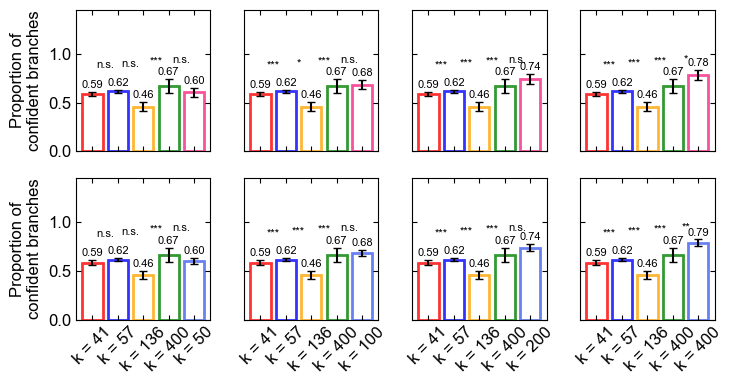

In [25]:
fig, axs = plt.subplots(2, 4, figsize=(7.5, 4), sharey=True, sharex=False)
x = np.arange(5)
colors_list = [['red', 'blue', 'orange', 'green', '#f72585'], ['red', 'blue', 'orange', 'green', '#4361ee']]
datasets = [lpp_kegg, lpp_eggnog]
xticklabels = [
    ['k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 50'],
    ['k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 100'],
    ['k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 200'],
    ['k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 400']
]

# Define a mapping for q-value datasets
q_value_mapping = [50, 100, 200, 400]

for row in range(2):
    for col in range(4):
        dataset = datasets[row] if col < 4 else lpp_previous
        means = [lpp_previous[:, i].mean() for i in range(4)] + [dataset[:, col].mean()]
        stds = [lpp_previous[:, i].std() for i in range(4)] + [dataset[:, col].std()]
        colors = colors_list[row]
        
        axs[row, col].bar(x, means, yerr=stds, capsize=3, lw=2, edgecolor=colors, color='none', alpha=0.8)
        for i, mean in enumerate(means):
            axs[row, col].text(x[i], mean + stds[i] + 0.02, f'{mean:.2f}', ha='center', va='bottom', fontsize=8)
        axs[row, col].tick_params(top=True, right=True, direction='in', which='both')
        axs[row, col].set_xticks(x)
        axs[row, col].set_xticklabels([] if row == 0 else xticklabels[col], rotation=45, ha='center')
        
        # Add q-values
        if row == 0 and col < 4:
            q_value_key = q_value_mapping[col]
            for i in range(len(ks_previous)):
                q_value = results_lpp_kegg[q_value_key].loc[i]['q-value']
                axs[row, col].text(x[i] + 0.5, 0.85 + i / 50, sig_sign(q_value), ha='center', fontsize=8, color='k')
        elif row == 1 and col < 4:
            q_value_key = q_value_mapping[col]
            for i in range(len(ks_previous)):
                q_value = results_lpp_eggnog[q_value_key].loc[i]['q-value']
                axs[row, col].text(x[i] + 0.5, 0.85 + i / 50, sig_sign(q_value), ha='center', fontsize=8, color='k')

axs[1, 3].set_ylim(0, 1.45)
axs[0, 0].set_ylabel(f'Proportion of\nconfident branches')
axs[1, 0].set_ylabel(f'Proportion of\nconfident branches')
# plt.savefig(f'./figures/lpp_taxonomic_imbalance.svg')
plt.show()

Col: 0
means: [0.6039630553687674, 0.5859185687248626, 0.6159768969127701, 0.45920599105646037, 0.6670059663925394, 0.6005898632155069]
stds: [0.04642600675218072, 0.021850241484152596, 0.01577070865149144, 0.04445826713842886, 0.07140900189099804, 0.029735262521876485]
Col: 1
means: [0.6847740227489505, 0.5859185687248626, 0.6159768969127701, 0.45920599105646037, 0.6670059663925394, 0.6822876615641691]
stds: [0.048235316133679, 0.021850241484152596, 0.01577070865149144, 0.04445826713842886, 0.07140900189099804, 0.027818847834076198]
Col: 2
means: [0.7401216598293658, 0.5859185687248626, 0.6159768969127701, 0.45920599105646037, 0.6670059663925394, 0.7401063239849354]
stds: [0.051023080705761684, 0.021850241484152596, 0.01577070865149144, 0.04445826713842886, 0.07140900189099804, 0.033719546246449746]
Col: 3
means: [0.7809591342009946, 0.5859185687248626, 0.6159768969127701, 0.45920599105646037, 0.6670059663925394, 0.7874918521188757]
stds: [0.053393674194987695, 0.021850241484152596, 0

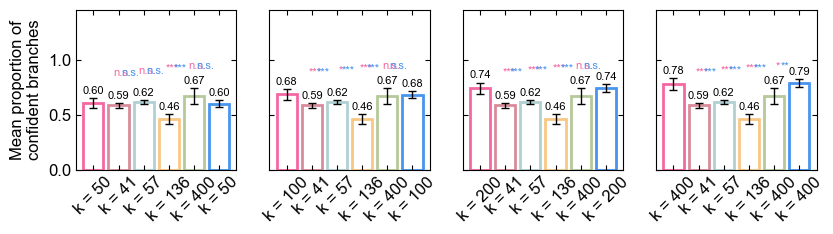

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(8.5, 2.5), sharey=True, sharex = False)
x = np.arange(6)
colors = ['#f467a1', '#d88c9a', '#b0d0d3', '#f9c784', '#b5c99a', '#4895ef']
# datasets = [lpp_kegg, lpp_eggnog]
xticklabels = [
    ['k = 50', 'k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 50'],
    ['k = 100', 'k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 100'],
    ['k = 200', 'k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 200'],
    ['k = 400', 'k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 400']
]

for col in range(4):
    means = [lpp_kegg[:, col].mean()] + [lpp_previous[:, i].mean() for i in range(4)] + [lpp_eggnog[:, col].mean()]
    stds = [lpp_kegg[:, col].std()] + [lpp_previous[:, i].std() for i in range(4)] + [lpp_eggnog[:, col].std()]
    print(f'Col: {col}\nmeans: {means}\nstds: {stds}')
    
    axs[col].bar(x, means, yerr=stds, capsize=3, lw=2, edgecolor=colors, color='none', alpha=1.0,
                error_kw = {'elinewidth': 1})
    for i, mean in enumerate(means):
        axs[col].text(x[i], mean + stds[i] + 0.02, f'{mean:.2f}', ha='center', va='bottom', fontsize=8)
    axs[col].tick_params(top=True, right=True, direction='in', which='both')
    axs[col].set_xticks(x)
    axs[col].set_xticklabels(xticklabels[col], rotation = 45, ha='center')

    # Add q-values
    q_value_key = q_value_mapping[col]
    for i in range(len(ks_previous)):
        q_value_kegg = results_lpp_kegg[q_value_key].loc[i]['q-value']
        q_value_eggnog = results_lpp_eggnog[q_value_key].loc[i]['q-value']
        axs[col].text(x[i] + 1.15, 0.85 + i / 50, sig_sign(q_value_kegg), ha='center', fontsize=8, color='#f467a1')
        axs[col].text(x[i] + 1.45, 0.85 + i / 50, sig_sign(q_value_eggnog), ha='center', fontsize=8, color='#4895ef')

    
axs[0].set_ylim(0, 1.45)
axs[0].set_ylabel(f'Mean proportion of\nconfident branches')
# axs[1, 0].set_ylabel(f'Proportion of\nconfident branches')
# plt.savefig(f'./figures/lpp_taxonomic_imbalance.svg')
plt.show()

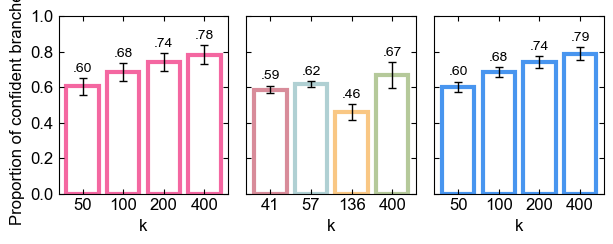

In [92]:
fig, axs = plt.subplots(1, 3, figsize=(6.3, 2.6), sharey=True, sharex = False)
x = np.arange(4)
colors = ['#d88c9a', '#b0d0d3', '#f9c784', '#b5c99a']
# datasets = [lpp_kegg, lpp_eggnog]
xticklabels_kegg_eggnog = [50, 100, 200, 400]
xticklabels_previous = [41, 57, 136, 400]

axs[0].bar(x, lpp_kegg.mean(axis = 0), yerr = lpp_kegg.std(axis = 0),
        edgecolor = '#f467a1', color = 'none', capsize = 3, lw = 3, error_kw = {'elinewidth': 1})
axs[0].tick_params(top=True, right=True, direction='in', which='both')
axs[0].set_xticks(x)
axs[0].set_xticklabels(xticklabels_kegg_eggnog, ha = 'center')
axs[0].set_xlabel(f'k')
axs[1].bar(x, lpp_previous.mean(axis = 0), yerr = lpp_previous.std(axis = 0),
        edgecolor = colors, color = 'none', capsize = 3, lw = 3, error_kw = {'elinewidth': 1})
axs[1].tick_params(top=True, right=True, direction='in', which='both')
axs[1].set_xticks(x)
axs[1].set_xticklabels(xticklabels_previous, ha = 'center')
axs[1].set_xlabel(f'k')
axs[2].bar(x, lpp_eggnog.mean(axis = 0), yerr = lpp_eggnog.std(axis = 0),
        edgecolor = '#4895ef', color = 'none', capsize = 3, lw = 3, error_kw = {'elinewidth': 1})
axs[2].tick_params(top=True, right=True, direction='in', which='both')
axs[2].set_xticks(x)
axs[2].set_xticklabels(xticklabels_kegg_eggnog, ha = 'center')
axs[2].set_xlabel(f'k')
# Add means as text
for i in x:
        axs[0].text(x[i], lpp_kegg.mean(axis = 0)[i] + lpp_kegg.std(axis = 0)[i] + 0.02, 
                f'{lpp_kegg.mean(axis = 0)[i] % 1:.2f}'[1:], ha = 'center', va = 'bottom', fontsize = 10)
        axs[1].text(x[i], lpp_previous.mean(axis = 0)[i] + lpp_previous.std(axis = 0)[i] + 0.02, 
                f'{lpp_previous.mean(axis = 0)[i] % 1:.2f}'[1:], ha = 'center', va = 'bottom', fontsize = 10)
        axs[2].text(x[i], lpp_eggnog.mean(axis = 0)[i] + lpp_eggnog.std(axis = 0)[i] + 0.02, 
                f'{lpp_eggnog.mean(axis = 0)[i] % 1:.2f}'[1:], ha = 'center', va = 'bottom', fontsize = 10)
      
axs[0].set_ylim(0, 1.0)
axs[0].set_ylabel(f'Proportion of confident branches')
plt.savefig(f'./figures/lpp_taxonomic_imbalance.svg')
plt.show()

In [65]:
results_lpp_kegg

{50:      comparison  statistic   p-value   q-value
 0   k1_50_k2_41       36.0  0.562188  0.635365
 1   k1_50_k2_57       25.0  0.635365  0.635365
 2  k1_50_k2_136       60.0  0.000250  0.000999
 3  k1_50_k2_400       16.0  0.147103  0.294206,
 100:       comparison  statistic   p-value   q-value
 0   k1_100_k2_41       59.0  0.000500  0.000999
 1   k1_100_k2_57       53.0  0.010989  0.014652
 2  k1_100_k2_136       60.0  0.000250  0.000999
 3  k1_100_k2_400       37.5  0.447365  0.447365,
 200:       comparison  statistic   p-value   q-value
 0   k1_200_k2_41       60.0  0.000250  0.000333
 1   k1_200_k2_57       60.0  0.000250  0.000333
 2  k1_200_k2_136       60.0  0.000250  0.000333
 3  k1_200_k2_400       48.0  0.055944  0.055944,
 400:       comparison  statistic   p-value   q-value
 0   k1_400_k2_41       60.0  0.000250  0.000333
 1   k1_400_k2_57       60.0  0.000250  0.000333
 2  k1_400_k2_136       60.0  0.000250  0.000333
 3  k1_400_k2_400       53.0  0.010989  0.010989}

In [66]:
results_lpp_eggnog

{50:      comparison  statistic   p-value   q-value
 0   k1_50_k2_41       37.5  0.447365  0.447365
 1   k1_50_k2_57       20.0  0.313187  0.417582
 2  k1_50_k2_136       60.0  0.000250  0.000999
 3  k1_50_k2_400        9.5  0.029939  0.059877,
 100:       comparison  statistic   p-value   q-value
 0   k1_100_k2_41       60.0  0.000250  0.000500
 1   k1_100_k2_57       59.0  0.000500  0.000666
 2  k1_100_k2_136       60.0  0.000250  0.000500
 3  k1_100_k2_400       40.0  0.313187  0.313187,
 200:       comparison  statistic   p-value   q-value
 0   k1_200_k2_41       60.0  0.000250  0.000333
 1   k1_200_k2_57       60.0  0.000250  0.000333
 2  k1_200_k2_136       60.0  0.000250  0.000333
 3  k1_200_k2_400       48.0  0.055944  0.055944,
 400:       comparison  statistic   p-value   q-value
 0   k1_400_k2_41       60.0  0.000250  0.000333
 1   k1_400_k2_57       60.0  0.000250  0.000333
 2  k1_400_k2_136       60.0  0.000250  0.000333
 3  k1_400_k2_400       54.0  0.007493  0.007493}

## Normalized Robinson-Foulds distance

In [67]:
replicates = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ks = [50, 100, 200, 400]

In [68]:
nrf_kegg = np.empty((len(replicates), len(ks)), dtype = float)
for i, rep in enumerate(replicates):
    for j, k in enumerate(ks):
        # Calculate nrf to WoL2
        nrf_kegg[i, j] = RF_distance(wol_tree, trees_kegg[rep][k])

In [69]:
nrf_kegg.shape

(10, 4)

In [70]:
nrf_eggnog = np.empty((len(replicates), len(ks)), dtype = float)
for i, rep in enumerate(replicates):
    for j, k in enumerate(ks):
        # Calculate nrf to WoL2
        nrf_eggnog[i, j] = RF_distance(wol_tree, trees_eggnog[rep][k])

In [71]:
nrf_eggnog.shape

(10, 4)

In [72]:
replicates =[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
markers = ['martinez_gutierrez', 'moody_2024', 'amphora', 'phylophlan']
ks = [41, 57, 136, 400]

In [73]:
nrf_previous = np.empty((len(replicates), len(markers)), dtype = float)
for i, rep in enumerate(replicates):
    for j, marker in enumerate(markers):
        # Get lpp values
        # Calculate nrf to WoL2
        nrf_previous[i, j] = RF_distance(wol_tree, trees_previous[rep][marker])

In [74]:
nrf_previous.shape

(10, 4)

Mann-Whitney test with Benjamini-Hochberg correction

In [75]:
ks_kegg_eggnog = [50, 100, 200, 400]
ks_previous = [41, 57, 136, 400]

In [76]:
results_nrf_kegg = {}
results_nrf_eggnog = {}
for i, k1 in enumerate(ks_kegg_eggnog):
    # Store p-values
    pvals_kegg = [] 
    pvals_eggnog = []
    for j, k2 in enumerate(ks_previous):
        stat_kegg, p_value_kegg = mannwhitneyu(nrf_kegg[:, i], nrf_previous[:, j])
        pvals_kegg.append([f'k1_{k1}_k2_{k2}', stat_kegg, p_value_kegg])
        stat_eggnog, p_value_eggnog = mannwhitneyu(nrf_eggnog[:, i], nrf_previous[:, j])
        pvals_eggnog.append([f'k1_{k1}_k2_{k2}', stat_eggnog, p_value_eggnog])
    # Store as dataframe
    results_nrf_kegg[k1] = pd.DataFrame(pvals_kegg, columns = ['comparison', 'statistic', 'p-value'])
    results_nrf_eggnog[k1] = pd.DataFrame(pvals_eggnog, columns = ['comparison', 'statistic', 'p-value'])
    # Correct p-values
    results_nrf_kegg[k1]['q-value'] = false_discovery_control(results_nrf_kegg[k1]['p-value'])
    results_nrf_eggnog[k1]['q-value'] = false_discovery_control(results_nrf_eggnog[k1]['p-value'])

Figure

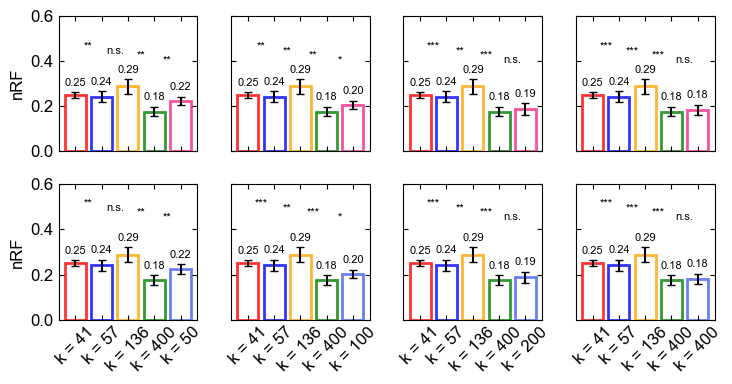

In [77]:
fig, axs = plt.subplots(2, 4, figsize=(7.5, 4), sharey=True, sharex=False)
x = np.arange(5)
colors_list = [['red', 'blue', 'orange', 'green', '#f72585'], ['red', 'blue', 'orange', 'green', '#4361ee']]
datasets = [nrf_kegg, nrf_eggnog]
xticklabels = [
    ['k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 50'],
    ['k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 100'],
    ['k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 200'],
    ['k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 400']
]

# Define a mapping for q-value datasets
q_value_mapping = [50, 100, 200, 400]

for row in range(2):
    for col in range(4):
        dataset = datasets[row] if col < 4 else nrf_previous
        means = [nrf_previous[:, i].mean() for i in range(4)] + [dataset[:, col].mean()]
        stds = [nrf_previous[:, i].std() for i in range(4)] + [dataset[:, col].std()]
        colors = colors_list[row]
        
        axs[row, col].bar(x, means, yerr=stds, capsize=3, lw=2, edgecolor=colors, color='none', alpha=0.8)
        for i, mean in enumerate(means):
            axs[row, col].text(x[i], mean + stds[i] + 0.02, f'{mean:.2f}', ha='center', va='bottom', fontsize=8)
        axs[row, col].tick_params(top=True, right=True, direction='in', which='both')
        axs[row, col].set_xticks(x)
        axs[row, col].set_xticklabels([] if row == 0 else xticklabels[col], rotation = 45, ha = 'center')

    # Add q-values
        if row == 0 and col < 4:
            q_value_key = q_value_mapping[col]
            for i in range(len(ks_previous)):
                q_value = results_nrf_kegg[q_value_key].loc[i]['q-value']
                axs[row, col].text(x[i] + 0.5, 0.45 - i / 50, sig_sign(q_value), ha='center', fontsize=8, color='k')
        elif row == 1 and col < 4:
            q_value_key = q_value_mapping[col]
            for i in range(len(ks_previous)):
                q_value = results_nrf_eggnog[q_value_key].loc[i]['q-value']
                axs[row, col].text(x[i] + 0.5, 0.5 - i / 50, sig_sign(q_value), ha='center', fontsize=8, color='k')

axs[1, 3].set_ylim(0, 0.6)
axs[0, 0].set_ylabel(f'nRF')
axs[1, 0].set_ylabel(f'nRF')
# plt.savefig(f'./figures/nrf_taxonomic_imbalance.svg')
plt.show()

Col: 0
means: [0.22381999482702994, 0.24906274236419984, 0.2414573703216718, 0.2876198332190928, 0.17628144880769273, 0.224552050744445]
stds: [0.01830729856256531, 0.01340680203054824, 0.02398700245177732, 0.03234050391065841, 0.021268597857166907, 0.021673784562618387]
Col: 1
means: [0.20472839570806597, 0.24906274236419984, 0.2414573703216718, 0.2876198332190928, 0.17628144880769273, 0.20278431734372498]
stds: [0.018645853732489424, 0.01340680203054824, 0.02398700245177732, 0.03234050391065841, 0.021268597857166907, 0.018823071996709986]
Col: 2
means: [0.18753331796620068, 0.24906274236419984, 0.2414573703216718, 0.2876198332190928, 0.17628144880769273, 0.1874610084101031]
stds: [0.02578330409696029, 0.01340680203054824, 0.02398700245177732, 0.03234050391065841, 0.021268597857166907, 0.023796500673477702]
Col: 3
means: [0.1834918713382253, 0.24906274236419984, 0.2414573703216718, 0.2876198332190928, 0.17628144880769273, 0.1805692165766137]
stds: [0.022377478059758694, 0.013406802030

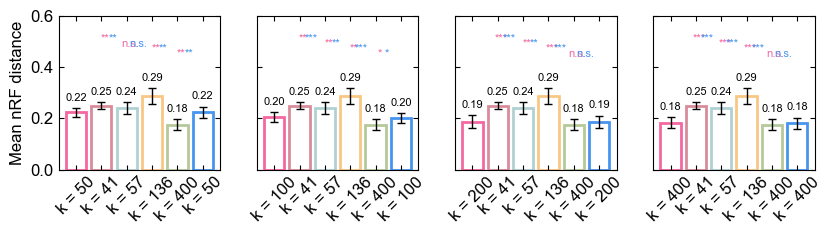

In [78]:
fig, axs = plt.subplots(1, 4, figsize=(8.5, 2.5), sharey=True, sharex = False)
x = np.arange(6)
colors = ['#f467a1', '#d88c9a', '#b0d0d3', '#f9c784', '#b5c99a', '#4895ef']
xticklabels = [
    ['k = 50', 'k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 50'],
    ['k = 100', 'k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 100'],
    ['k = 200', 'k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 200'],
    ['k = 400', 'k = 41', 'k = 57', 'k = 136', 'k = 400', 'k = 400']
]

for col in range(4):
    means = [nrf_kegg[:, col].mean()] + [nrf_previous[:, i].mean() for i in range(4)] + [nrf_eggnog[:, col].mean()]
    stds = [nrf_kegg[:, col].std()] + [nrf_previous[:, i].std() for i in range(4)] + [nrf_eggnog[:, col].std()]
    print(f'Col: {col}\nmeans: {means}\nstds: {stds}')
    
    axs[col].bar(x, means, yerr=stds, capsize=3, lw=2, edgecolor=colors, color='none', alpha=1.0,
                error_kw = {'elinewidth': 1})
    for i, mean in enumerate(means):
        axs[col].text(x[i], mean + stds[i] + 0.02, f'{mean:.2f}', ha='center', va='bottom', fontsize=8)
    axs[col].tick_params(top=True, right=True, direction='in', which='both')
    axs[col].set_xticks(x)
    axs[col].set_xticklabels(xticklabels[col], rotation = 45, ha='center')

    # Add q-values
    q_value_key = q_value_mapping[col]
    for i in range(len(ks_previous)):
        q_value_kegg = results_nrf_kegg[q_value_key].loc[i]['q-value']
        q_value_eggnog = results_nrf_eggnog[q_value_key].loc[i]['q-value']
        axs[col].text(x[i] + 1.15, 0.5 - i / 50, sig_sign(q_value_kegg), ha='center', fontsize=8, color='#f467a1')
        axs[col].text(x[i] + 1.45, 0.5 - i / 50, sig_sign(q_value_eggnog), ha='center', fontsize=8, color='#4895ef')
   
axs[0].set_ylim(0, 0.6)
axs[0].set_ylabel(f'Mean nRF distance')
# plt.savefig(f'./figures/nrf_taxonomic_imbalance.svg')
plt.show()

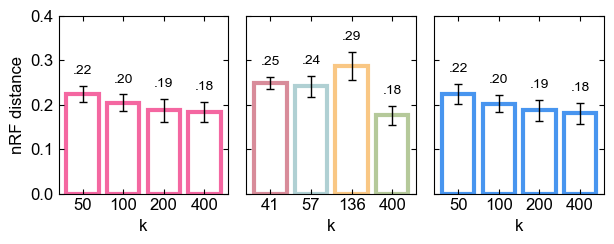

In [91]:
fig, axs = plt.subplots(1, 3, figsize=(6.3, 2.6), sharey=True, sharex = False)
x = np.arange(4)
colors = ['#d88c9a', '#b0d0d3', '#f9c784', '#b5c99a']
xticklabels_kegg_eggnog = [50, 100, 200, 400]
xticklabels_previous = [41, 57, 136, 400]

axs[0].bar(x, nrf_kegg.mean(axis = 0), yerr = nrf_kegg.std(axis = 0),
        edgecolor = '#f467a1', color = 'none', capsize = 3, lw = 3, error_kw = {'elinewidth': 1})
axs[0].tick_params(top=True, right=True, direction='in', which='both')
axs[0].set_xticks(x)
axs[0].set_xticklabels(xticklabels_kegg_eggnog, ha = 'center')
axs[0].set_xlabel(f'k')
axs[1].bar(x, nrf_previous.mean(axis = 0), yerr = nrf_previous.std(axis = 0),
        edgecolor = colors, color = 'none', capsize = 3, lw = 3, error_kw = {'elinewidth': 1})
axs[1].tick_params(top=True, right=True, direction='in', which='both')
axs[1].set_xticks(x)
axs[1].set_xticklabels(xticklabels_previous, ha = 'center')
axs[1].set_xlabel(f'k')
axs[2].bar(x, nrf_eggnog.mean(axis = 0), yerr = nrf_eggnog.std(axis = 0),
        edgecolor = '#4895ef', color = 'none', capsize = 3, lw = 3, error_kw = {'elinewidth': 1})
axs[2].tick_params(top=True, right=True, direction='in', which='both')
axs[2].set_xticks(x)
axs[2].set_xticklabels(xticklabels_kegg_eggnog, ha = 'center')
axs[2].set_xlabel(f'k')
# Add means as text
for i in x:
        axs[0].text(x[i], nrf_kegg.mean(axis = 0)[i] + nrf_kegg.std(axis = 0)[i] + 0.02, 
                f'{nrf_kegg.mean(axis = 0)[i] % 1:.2f}'[1:], ha = 'center', va = 'bottom', fontsize = 10)
        axs[1].text(x[i], nrf_previous.mean(axis = 0)[i] + nrf_previous.std(axis = 0)[i] + 0.02, 
                f'{nrf_previous.mean(axis = 0)[i] % 1:.2f}'[1:], ha = 'center', va = 'bottom', fontsize = 10)
        axs[2].text(x[i], nrf_eggnog.mean(axis = 0)[i] + nrf_eggnog.std(axis = 0)[i] + 0.02, 
                f'{nrf_eggnog.mean(axis = 0)[i] % 1:.2f}'[1:], ha = 'center', va = 'bottom', fontsize = 10)
      
axs[0].set_ylim(0, 0.4)
axs[0].set_ylabel(f'nRF distance')
plt.savefig(f'./figures/nrf_taxonomic_imbalance.svg')
plt.show()

In [ ]:
results_nrf_kegg

In [ ]:
results_nrf_eggnog